# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

15:56:23 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=790861;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=783458;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=992509;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=139716;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

<Table length=1>
    name        ra     dec    trigger_time   t90  
   object    float64 float64    float64    float64
------------ ------- ------- ------------- -------
GRB080916009 119.800 -56.600 54725.0088613  62.977

To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

15:57:23 INFO      Auto-determined polynomial order: 0                                ]8;id=215333;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=504202;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

15:57:40 INFO      None 0-order polynomial fit with the mle method                               ]8;id=291399;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=828516;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=691020;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=613701;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=619790;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=157018;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=286598;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=319735;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=342031;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=146554;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

15:57:41 INFO      Auto-probed noise models:                                                    ]8;id=643308;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=836908;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#484\484]8;;\

         INFO      - observation: poisson                                                       ]8;id=47332;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=949637;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - background: gaussian                                                       ]8;id=102933;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=756986;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=360352;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=134763;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

15:57:44 INFO      Now using 120 bins                                                          ]8;id=687831;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=814543;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

15:57:46 INFO      Auto-determined polynomial order: 1                                ]8;id=209320;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=639440;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

15:58:04 INFO      None 1-order polynomial fit with the mle method                               ]8;id=838303;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=327219;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=669734;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=798708;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=927088;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=975795;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=402681;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=201035;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=458197;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=317894;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

15:58:05 INFO      Auto-probed noise models:                                                    ]8;id=177208;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=971829;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#484\484]8;;\

         INFO      - observation: poisson                                                       ]8;id=575392;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=425564;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - background: gaussian                                                       ]8;id=89267;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=5559;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=166333;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=98705;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=560682;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=447710;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

15:58:07 INFO      Auto-determined polynomial order: 1                                ]8;id=740008;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=924359;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

15:58:25 INFO      None 1-order polynomial fit with the mle method                               ]8;id=557713;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=250909;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=940654;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=253782;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=169129;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=561172;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=665451;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=130546;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=88939;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=177381;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

15:58:26 INFO      Auto-probed noise models:                                                    ]8;id=174244;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=539860;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#484\484]8;;\

         INFO      - observation: poisson                                                       ]8;id=256867;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=719895;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - background: gaussian                                                       ]8;id=176188;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=536414;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=184154;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=525832;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=760971;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=530284;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

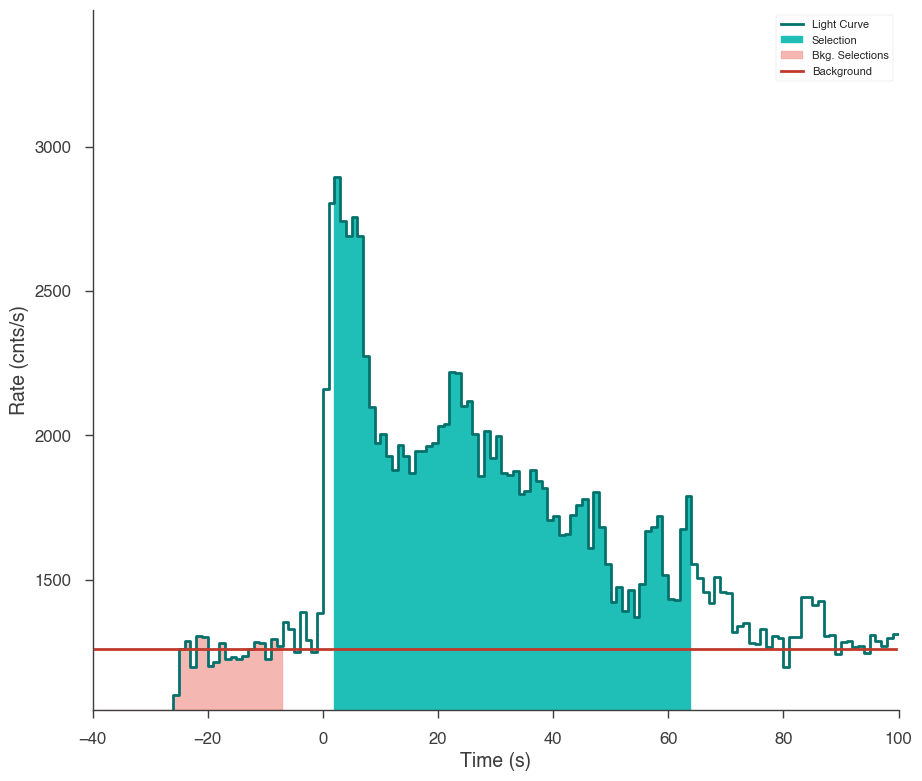

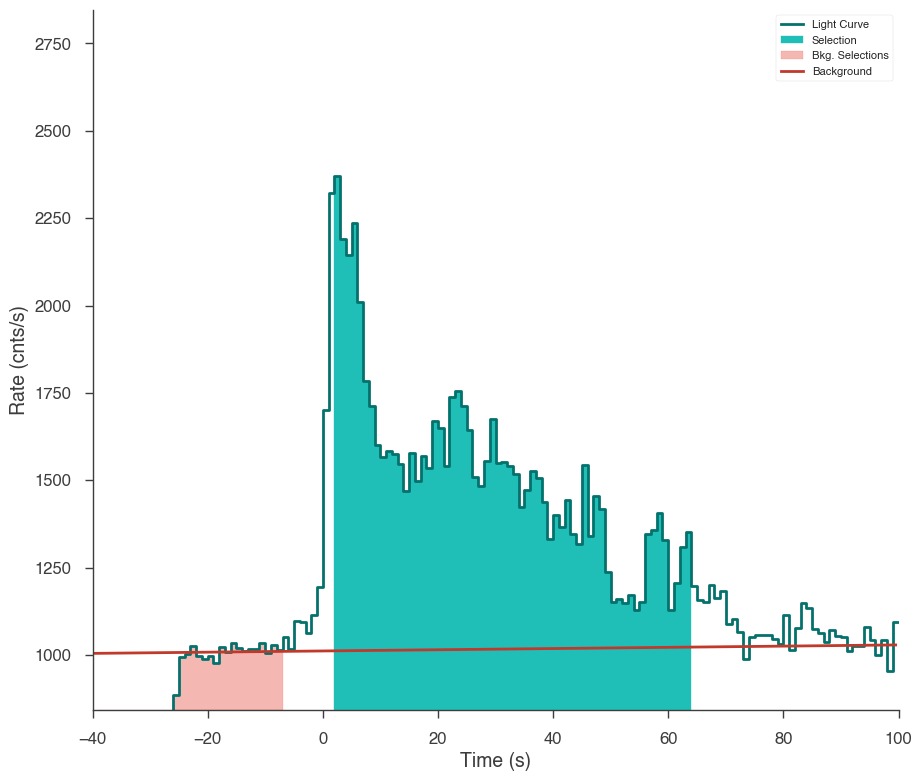

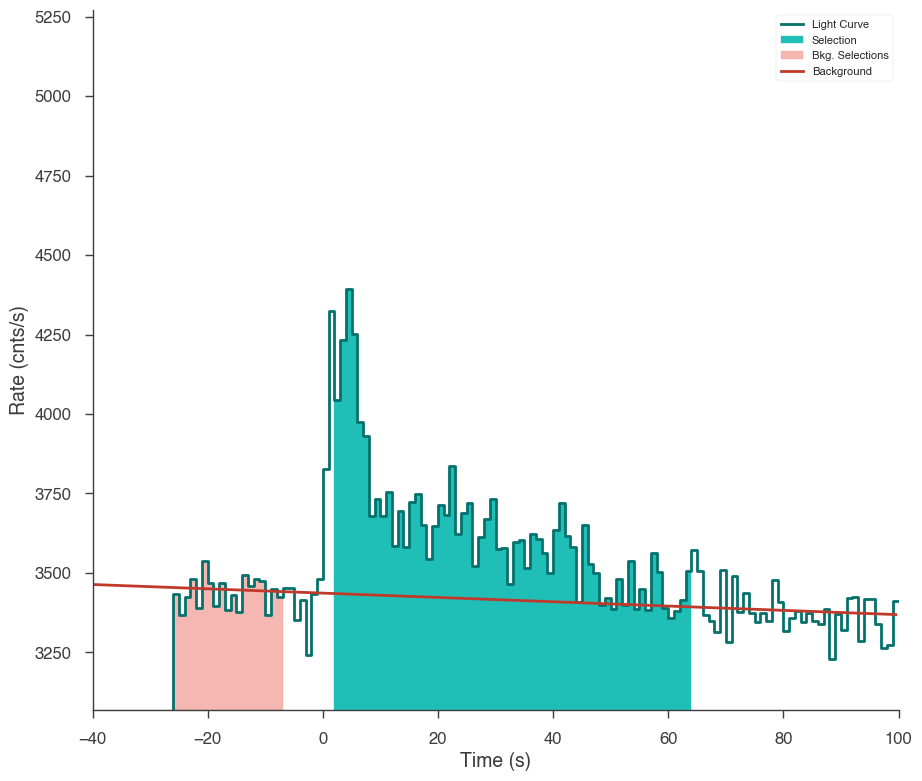

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

         INFO      sampler set to multinest                                                ]8;id=646418;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=288165;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

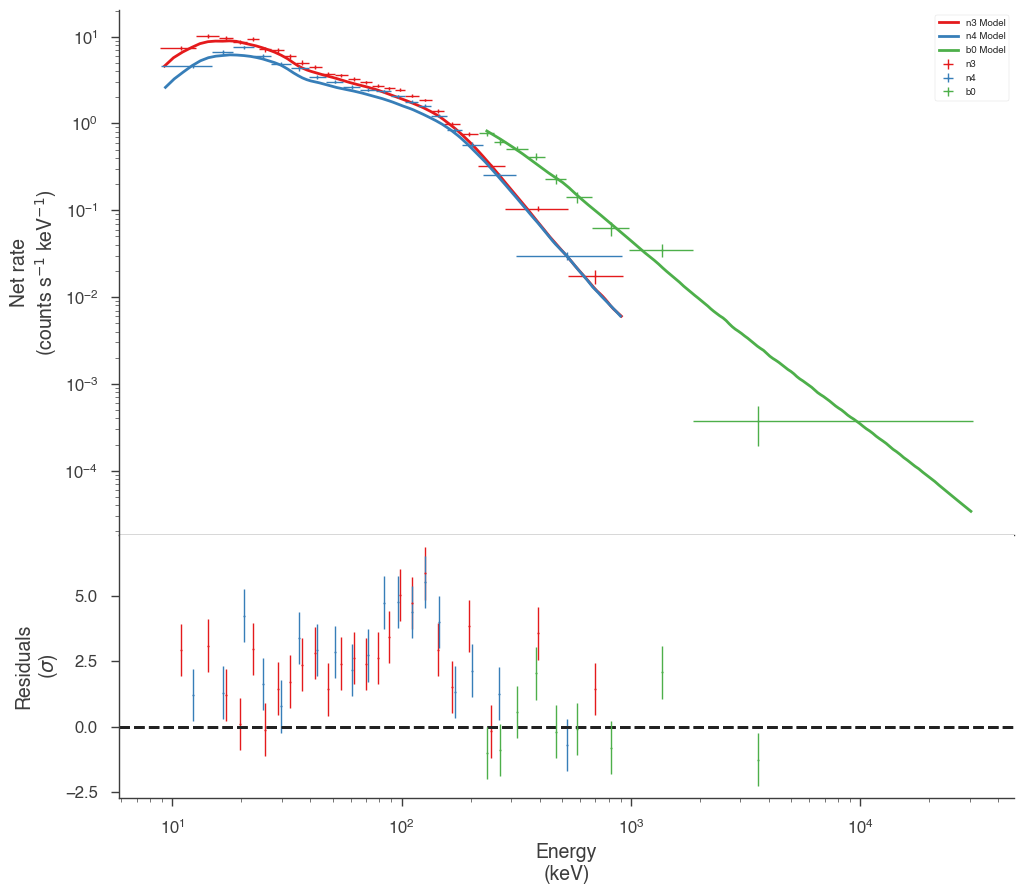

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -3102.8482267409363      +/-  0.23071440635378163     
 Total Likelihood Evaluations:        21507
 Sampling finished. Exiting MultiNest



15:58:50 INFO      fit restored to maximum of posterior                                         ]8;id=55419;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=489850;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=540076;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=90653;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
GRB080916009...K             (1.469 -0.022 +0.005) x 10^-2  1 / (cm2 keV s)
GRB080916009...alpha                  -1.090 -0.010 +0.018                 
GRB080916009...break_energy     (1.922 -0.011 +0.4) x 10^2              keV
GRB080916009...break_scale         (0.0 +0.6 +2.7) x 10^-1                 
GRB080916009...beta                      -2.01 -0.09 +0.05

Values of -log(posterior) at the minimum:

-log(posterior)
b0        -1049.037567
n3        -1020.284859
n4        -1010.075544
total     -3079.397970

Values of statistical measures:

statistical measures
AIC              6168.966395
BIC              6188.198606
DIC              6177.201003
PDIC                2.706492
log(Z)          -1347.549863

Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=686227;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=514531;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

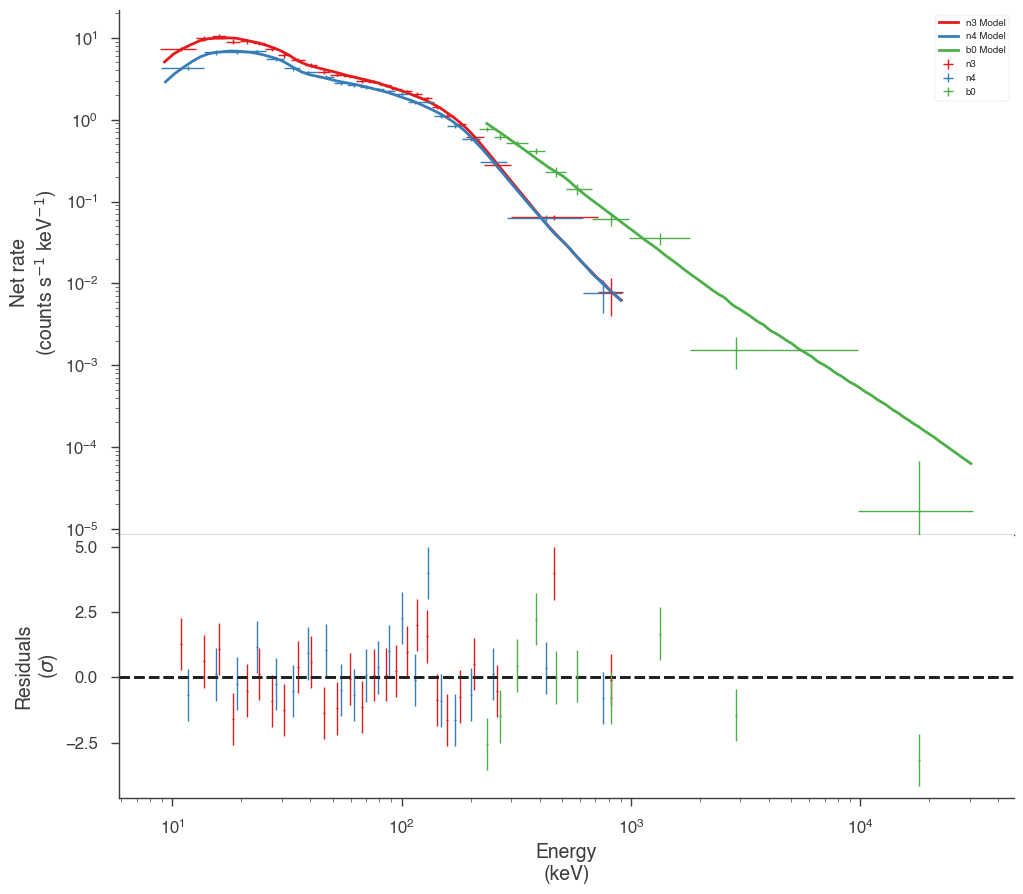

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

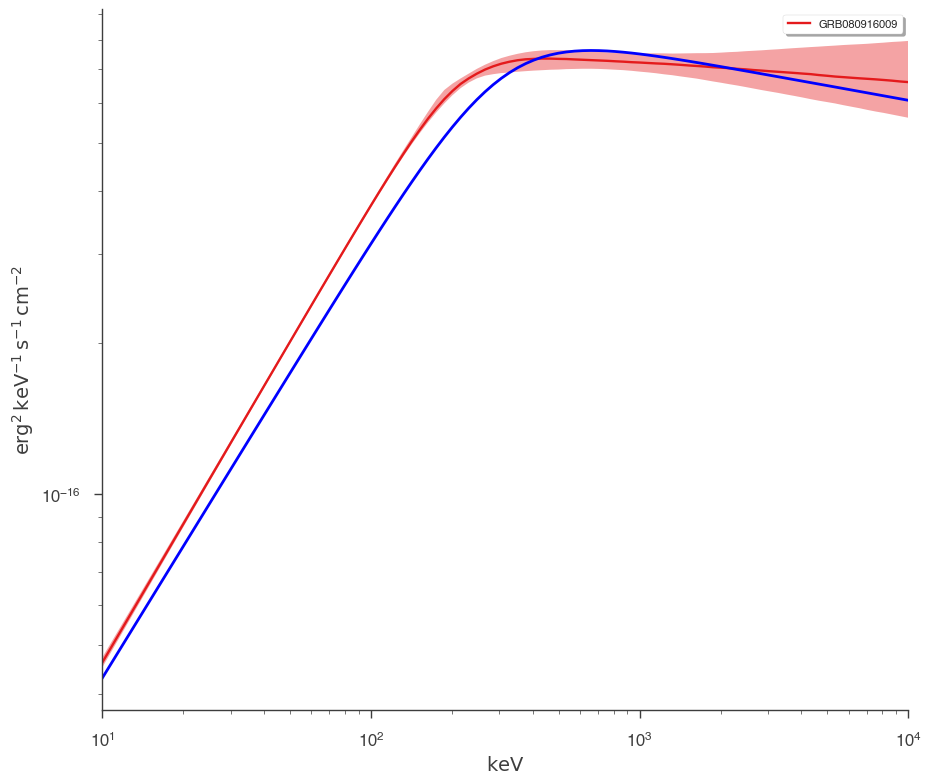

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

16:00:54 INFO      Created 15 bins via bayesblocks                                       ]8;id=320065;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=355484;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


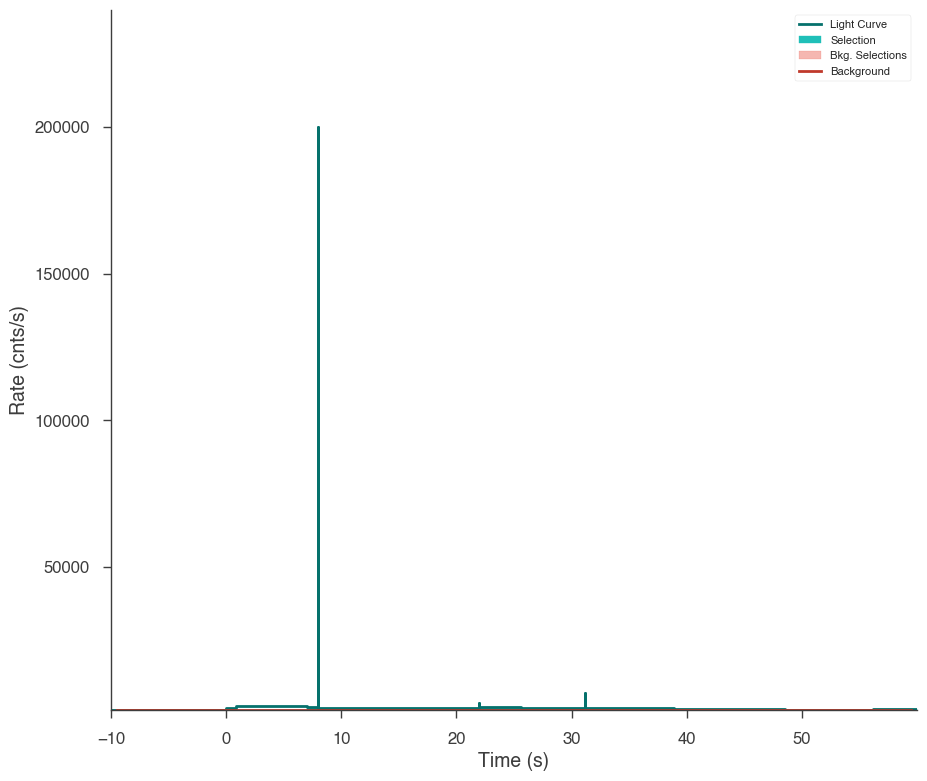

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

16:00:55 INFO      Created 12 bins via custom                                            ]8;id=942727;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=153279;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

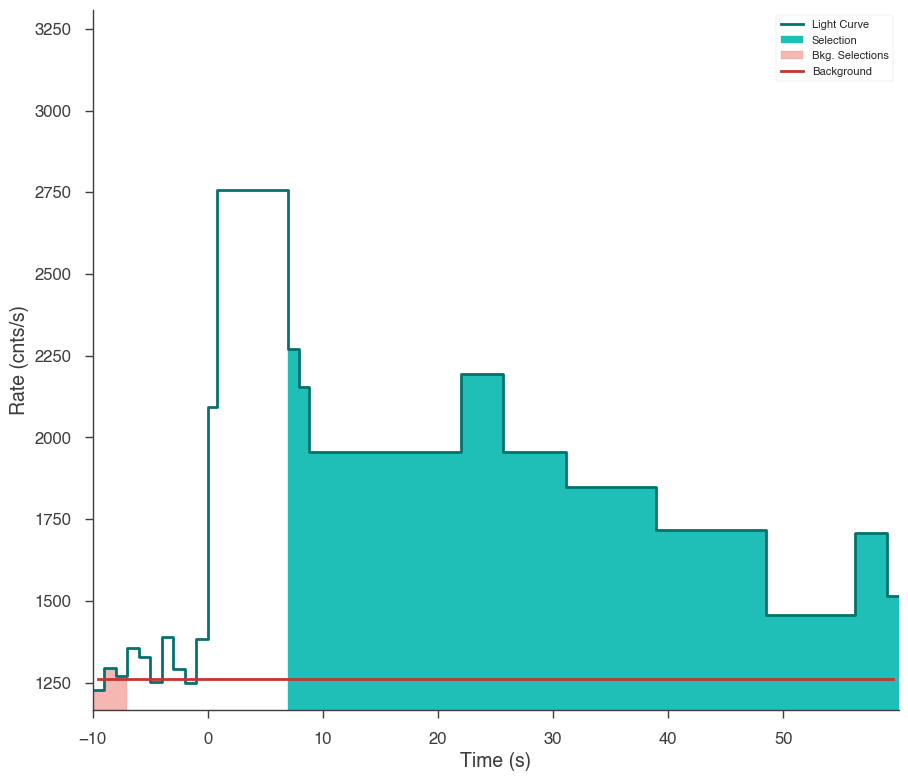

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

         INFO      Created 12 bins via custom                                            ]8;id=735551;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=351881;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=164034;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=989583;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=605989;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=573704;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

16:00:56 INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=515310;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=63243;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=899129;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=949041;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

16:00:57 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=572683;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=503002;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=208477;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=572515;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=843067;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=554221;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=165975;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=465919;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=80115;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=271921;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=170828;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=688273;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 107 bins                                                          ]8;id=679074;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=121815;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=697820;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=120950;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.46699680991787      +/-  0.17770398758120626     
 Total Likelihood Evaluations:        16586
 Sampling finished. Exiting MultiNest



16:01:13 INFO      fit restored to maximum of posterior                                         ]8;id=864068;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=568895;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=534892;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=195256;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K         (3.5 +/- 0.5) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-5.5 -1.2 +1.1) x 10^-1                 
grb.spectrum.main.Band.xp     (3.11 -0.33 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta           -2.03 -0.4 +0.05

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval0      -285.695083
n3_interval0      -250.100869
n4_interval0      -267.938941
total             -803.734893

Values of statistical measures:

statistical measures
AIC              1615.583100
BIC              1630.991918
DIC              1570.239652
PDIC                2.503959
log(Z)           -342.426866

16:01:14 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=42146;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=540797;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=961919;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=628628;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=578472;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=712539;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=552660;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=563369;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=813426;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=937784;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=946449;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=438320;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=508341;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=793277;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1962.7793060240747      +/-  0.27984145195846594     
 Total Likelihood Evaluations:        22669
 Sampling finished. Exiting MultiNest



16:01:37 INFO      fit restored to maximum of posterior                                         ]8;id=332161;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=842860;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=482194;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=214061;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                   
grb.spectrum.main.Band.K      (4.489 -0.024 +0.020) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-7.90 -0.06 +0.11) x 10^-1                 
grb.spectrum.main.Band.xp         (5.04 -0.08 +0.06) x 10^2              keV
grb.spectrum.main.Band.beta            -2.003 -0.014 +0.010

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval1      -676.710506
n3_interval1      -641.821570
n4_interval1      -643.725802
total            -1962.257878

Values of statistical measures:

statistical measures
AIC              3932.629071
BIC              3948.037888
DIC              3874.443760
PDIC                1.023223
log(Z)           -852.424222

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=729903;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=200708;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=580531;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=888264;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=198940;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=476297;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=3744;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=995387;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=263433;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=439181;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 115 bins                                                          ]8;id=577415;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=308160;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=238558;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=305510;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -909.54292363463867      +/-  0.18971482609008317     
 Total Likelihood Evaluations:        19352
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


16:01:56 INFO      fit restored to maximum of posterior                                         ]8;id=695263;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=956684;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=646842;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=78833;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (2.83 +0.05 +0.6) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha        -1.000 -0.004 +0.13                 
grb.spectrum.main.Band.xp      (3.90 -1.1 -0.14) x 10^2              keV
grb.spectrum.main.Band.beta           -1.71 -0.04 +0.06

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval2      -324.063632
n3_interval2      -288.578731
n4_interval2      -310.447255
total             -923.089618

Values of statistical measures:

statistical measures
AIC              1854.292550
BIC              1869.701368
DIC              1806.722728
PDIC                2.339062
log(Z)           -395.009473

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=381119;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=51993;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=378978;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=921445;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=329196;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=666585;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=710351;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=814182;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=807709;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=862218;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 109 bins                                                          ]8;id=53062;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=617357;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=895812;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=227326;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.32730248387429      +/-  0.17786632323101517     
 Total Likelihood Evaluations:        16870
 Sampling finished. Exiting MultiNest



16:02:13 INFO      fit restored to maximum of posterior                                         ]8;id=163988;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=727945;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=837679;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=297060;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                               
grb.spectrum.main.Band.K      (2.88 -0.26 +0.4) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha   (-9.2 -0.8 +0.9) x 10^-1                 
grb.spectrum.main.Band.xp        (3.4 -0.6 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta            -2.25 -0.5 +0.14

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval3      -298.404812
n3_interval3      -242.495415
n4_interval3      -262.578893
total             -803.479121

Values of statistical measures:

statistical measures
AIC              1615.071556
BIC              1630.480374
DIC              1570.542907
PDIC                2.953220
log(Z)           -342.366197

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=156083;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=108062;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=574913;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=692957;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=358693;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=376723;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=111942;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=367993;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=961148;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=294175;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=475107;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=398087;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=956876;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=302484;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2270.5783041599825      +/-  0.19766292375150499     
 Total Likelihood Evaluations:        20180
 Sampling finished. Exiting MultiNest



16:02:32 INFO      fit restored to maximum of posterior                                         ]8;id=743215;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=890069;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=421214;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=408593;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (2.03 -0.10 +0.13) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-9.89 -0.35 +0.4) x 10^-1                 
grb.spectrum.main.Band.xp         (4.0 -0.5 +0.6) x 10^2              keV
grb.spectrum.main.Band.beta            -1.97 -0.12 +0.07

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval4      -778.528961
n3_interval4      -757.022170
n4_interval4      -746.945313
total            -2282.496444

Values of statistical measures:

statistical measures
AIC              4573.106202
BIC              4588.515020
DIC              4527.814191
PDIC                3.410479
log(Z)           -986.099628

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=534898;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=567488;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=417471;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=228435;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=873952;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=34559;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=323897;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=569139;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=771611;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=545545;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=776149;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=235924;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=783981;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=996075;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1584.3853437070304      +/-  0.21125456827102060     
 Total Likelihood Evaluations:        20226
 Sampling finished. Exiting MultiNest



16:02:53 INFO      fit restored to maximum of posterior                                         ]8;id=252175;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=527918;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=547544;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=946461;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                  
grb.spectrum.main.Band.K      (3.351 +0.030 +0.25) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-8.32 -0.05 +0.5) x 10^-1                 
grb.spectrum.main.Band.xp        (2.99 -0.29 -0.05) x 10^2              keV
grb.spectrum.main.Band.beta     -1.915140 +0.000033 +0.028

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval5      -536.020325
n3_interval5      -524.695816
n4_interval5      -529.056679
total            -1589.772820

Values of statistical measures:

statistical measures
AIC              3187.658954
BIC              3203.067772
DIC              3145.988440
PDIC                1.915553
log(Z)           -688.089812

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=917573;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=983533;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=466604;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=209960;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=129437;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=805504;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=243800;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=417046;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=589062;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=784520;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=461043;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=757708;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=906671;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=104879;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1755.0656836159749      +/-  0.19128013890439108     
 Total Likelihood Evaluations:        20400
 Sampling finished. Exiting MultiNest



16:03:12 INFO      fit restored to maximum of posterior                                         ]8;id=127629;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=23224;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=879118;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=863196;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.94 -0.12 +0.13) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha              -1.01 +/- 0.05                 
grb.spectrum.main.Band.xp         (4.6 -0.6 +0.7) x 10^2              keV
grb.spectrum.main.Band.beta             -2.36 -0.4 +0.18

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval6      -609.728145
n3_interval6      -584.225132
n4_interval6      -576.970738
total            -1770.924015

Values of statistical measures:

statistical measures
AIC              3549.961344
BIC              3565.370162
DIC              3501.584449
PDIC                3.527206
log(Z)           -762.215342

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=476362;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=510020;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=751175;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=24824;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=739827;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=792730;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=779740;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=389768;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=566135;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=461919;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=699808;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=755694;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=801555;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=90112;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1943.4010233088209      +/-  0.20026915253986774     
 Total Likelihood Evaluations:        19787
 Sampling finished. Exiting MultiNest



16:03:35 INFO      fit restored to maximum of posterior                                         ]8;id=542396;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=316962;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=354988;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=718212;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.75 +0.05 +0.20) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha         -1.021 +0.025 +0.09                 
grb.spectrum.main.Band.xp       (3.83 -0.7 -0.16) x 10^2              keV
grb.spectrum.main.Band.beta        -2.0862 -0.0035 +0.12

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval7      -662.139880
n3_interval7      -641.258379
n4_interval7      -649.298582
total            -1952.696841

Values of statistical measures:

statistical measures
AIC              3913.506997
BIC              3928.915815
DIC              3869.309859
PDIC                2.250798
log(Z)           -844.008341

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=431997;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=802553;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=349706;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=932774;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=789284;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=352590;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=463560;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=335342;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=152438;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=870788;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=26798;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=552227;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=598730;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=497341;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2053.6241614730402      +/-  0.18621510213412193     
 Total Likelihood Evaluations:        20337
 Sampling finished. Exiting MultiNest



16:03:53 INFO      fit restored to maximum of posterior                                         ]8;id=651488;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=58404;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=739474;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=767419;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K      (1.54 -0.14 +0.10) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-8.4 -0.8 +0.5) x 10^-1                 
grb.spectrum.main.Band.xp       (3.69 -0.31 +0.7) x 10^2              keV
grb.spectrum.main.Band.beta             -2.30 -0.4 +0.12

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval8      -702.059996
n3_interval8      -698.424609
n4_interval8      -666.222425
total            -2066.707030

Values of statistical measures:

statistical measures
AIC              4141.527375
BIC              4156.936193
DIC              4098.336983
PDIC                3.347612
log(Z)           -891.877641

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=290341;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=339619;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=639884;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=165016;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=408971;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=566050;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=471082;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=401591;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=907396;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=923032;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=23675;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=933915;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=14912;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=92194;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1879.8350886626326      +/-  0.15229670798583175     
 Total Likelihood Evaluations:        12093
 Sampling finished. Exiting MultiNest



16:04:06 INFO      fit restored to maximum of posterior                                         ]8;id=587457;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=86329;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=477724;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=841992;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                                
grb.spectrum.main.Band.K       (1.06 -0.08 +1.0) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-8.80 -0.22 +3.1) x 10^-1                 
grb.spectrum.main.Band.xp       (1.19 -0.5 +0.14) x 10^2              keV
grb.spectrum.main.Band.beta            -1.91 -0.24 +0.16

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval9      -648.320526
n3_interval9      -617.137238
n4_interval9      -616.392582
total            -1881.850346

Values of statistical measures:

statistical measures
AIC              3771.814007
BIC              3787.222825
DIC              3742.018007
PDIC               -4.546964
log(Z)           -816.402006

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=280574;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=948006;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=60805;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=2426;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=922252;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=1669;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=856456;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=529528;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=358411;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=772762;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=143090;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=179460;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=543548;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=943231;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1322.4516214436492      +/-  0.16956152658376034     
 Total Likelihood Evaluations:        15162
 Sampling finished. Exiting MultiNest



16:04:21 INFO      fit restored to maximum of posterior                                         ]8;id=849606;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=343792;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=129805;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=550577;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K       (2.1 -0.5 +0.4) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha  (-7.2 -1.7 +1.1) x 10^-1                 
grb.spectrum.main.Band.xp     (2.11 -0.32 +0.8) x 10^2              keV
grb.spectrum.main.Band.beta          -1.93 -0.30 +0.06

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval10      -460.793195
n3_interval10      -437.642750
n4_interval10      -433.087247
total             -1331.523192

Values of statistical measures:

statistical measures
AIC              2671.159698
BIC              2686.568515
DIC              2633.539133
PDIC                0.223242
log(Z)           -574.333442

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=625273;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=704461;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 120 bins                                                          ]8;id=116106;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=557562;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=389218;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=376131;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=567744;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=107820;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=564014;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=439179;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1241\1241]8;;\

         INFO      Now using 119 bins                                                          ]8;id=765358;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=389646;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1733\1733]8;;\

         INFO      sampler set to multinest                                                ]8;id=477637;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=515460;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -812.57817773156125      +/-  0.14854844651547766     
 Total Likelihood Evaluations:        12114
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


16:04:34 INFO      fit restored to maximum of posterior                                         ]8;id=356707;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=245218;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=921115;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=171165;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

result             unit
parameter                                                              
grb.spectrum.main.Band.K       (2.8 -0.8 +3.3) x 10^-2  1 / (cm2 keV s)
grb.spectrum.main.Band.alpha    (-5.0 -2.1 +4) x 10^-1                 
grb.spectrum.main.Band.xp     (1.26 -0.4 +0.18) x 10^2              keV
grb.spectrum.main.Band.beta          -2.08 -0.12 +0.27

Values of -log(posterior) at the minimum:

-log(posterior)
b0_interval11      -292.269697
n3_interval11      -272.447527
n4_interval11      -255.695839
total              -820.413063

Values of statistical measures:

statistical measures
AIC              1648.939440
BIC              1664.348257
DIC              1613.253536
PDIC               -3.938191
log(Z)           -352.898219

### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=530333;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=163287;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:04:35 INFO      fit restored to median of posterior                                          ]8;id=287934;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=753147;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=178909;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=833366;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:04:36 INFO      fit restored to median of posterior                                          ]8;id=527334;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=551854;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:04:37 INFO      fit restored to median of posterior                                          ]8;id=986234;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=114903;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:04:38 INFO      fit restored to median of posterior                                          ]8;id=77965;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=531649;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:04:39 INFO      fit restored to median of posterior                                          ]8;id=81084;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=470261;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:04:40 INFO      fit restored to median of posterior                                          ]8;id=426335;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=79445;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:04:41 INFO      fit restored to median of posterior                                          ]8;id=265155;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=476321;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:04:42 INFO      fit restored to median of posterior                                          ]8;id=948312;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=435435;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=799260;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=523311;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

16:04:44 INFO      fit restored to median of posterior                                          ]8;id=993763;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=813722;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

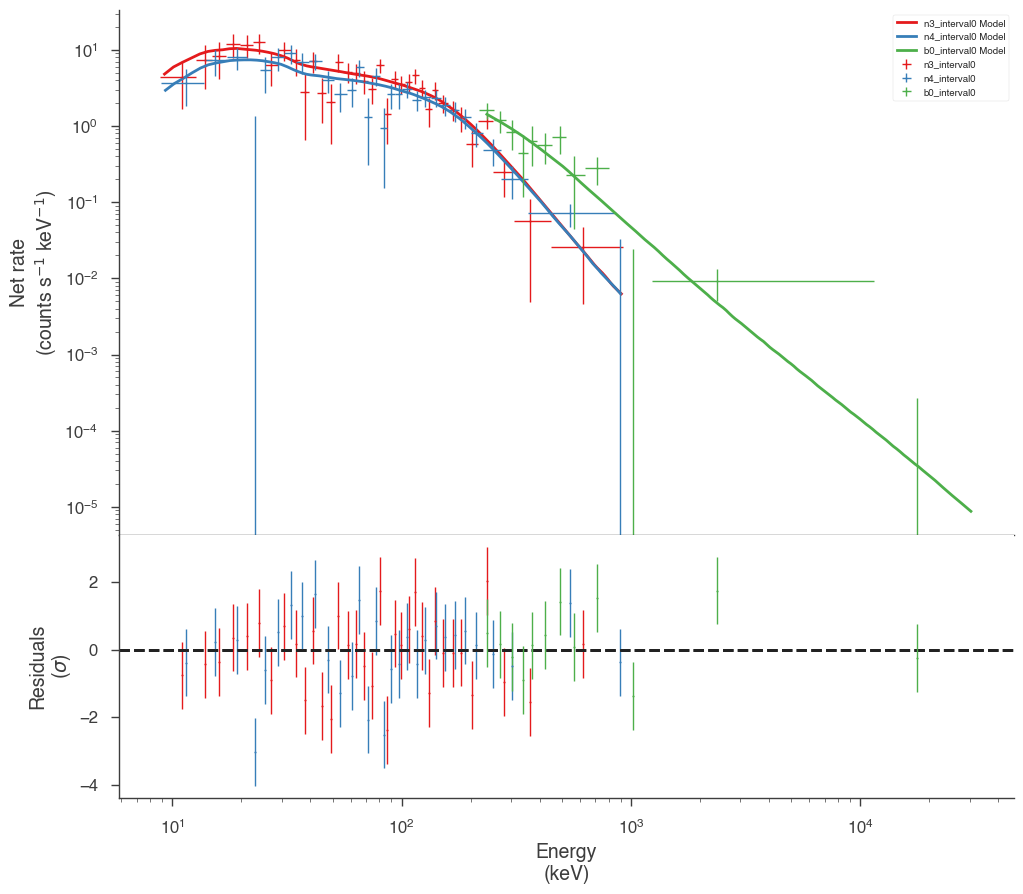

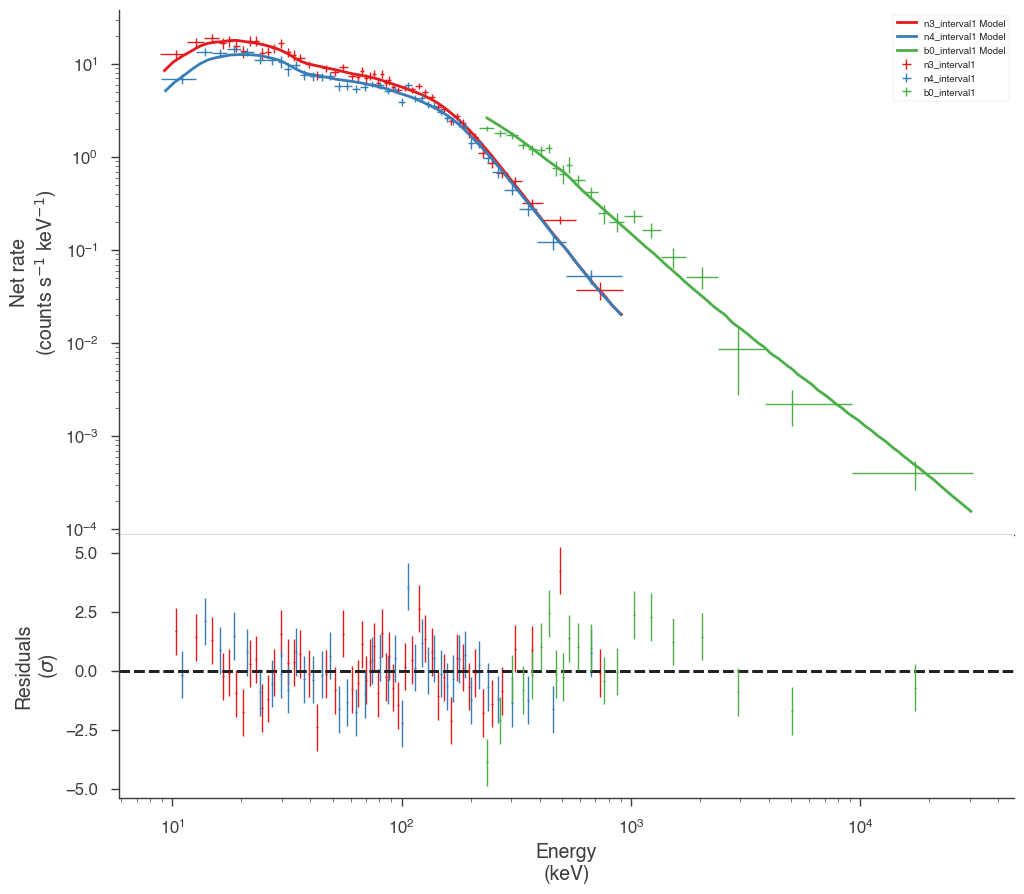

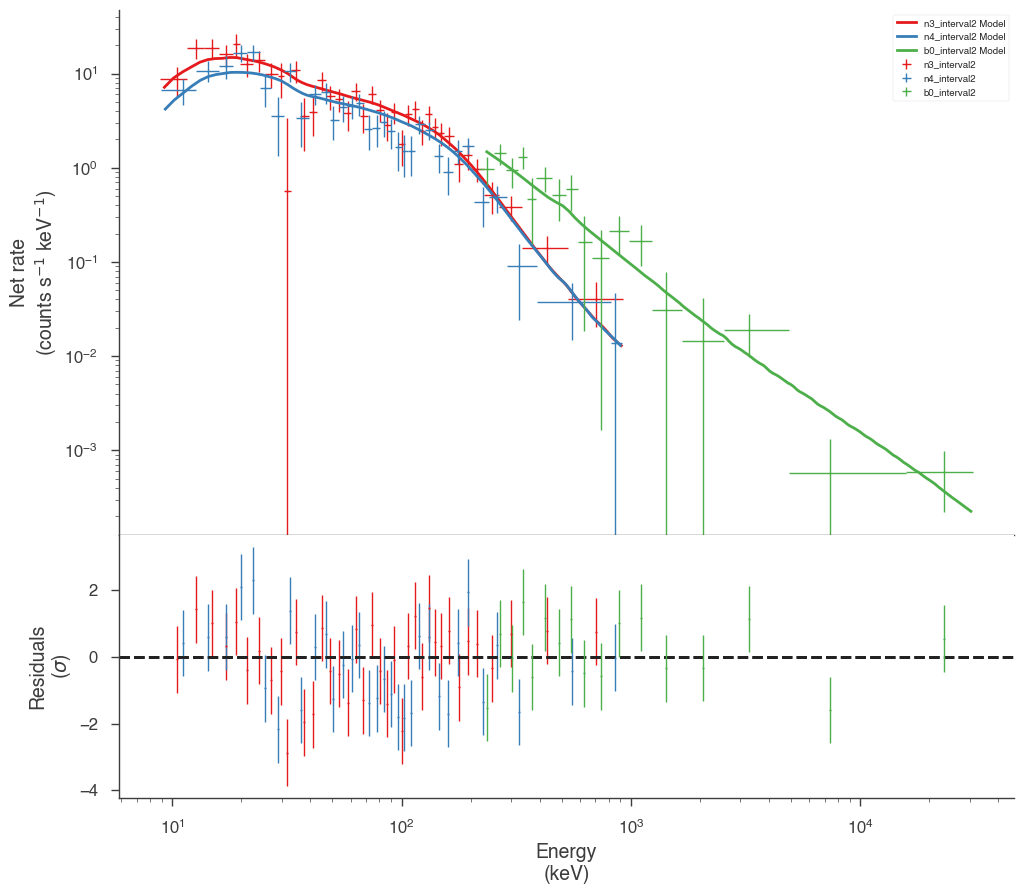

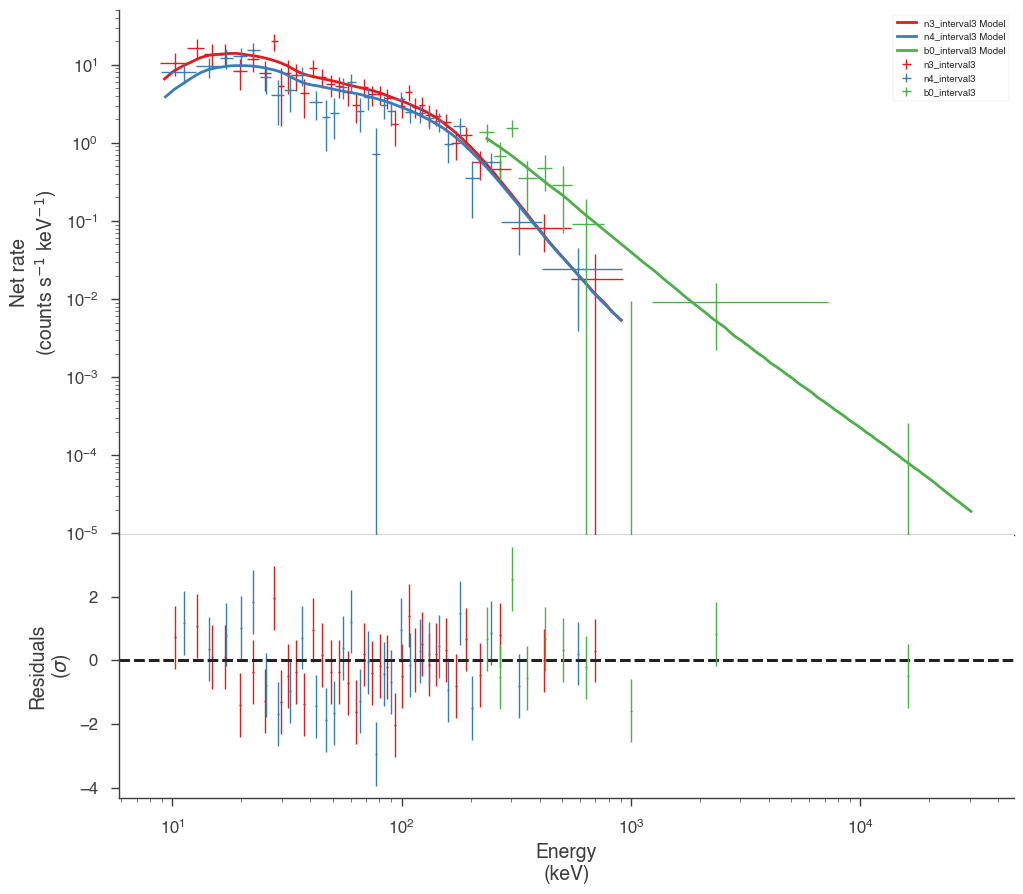

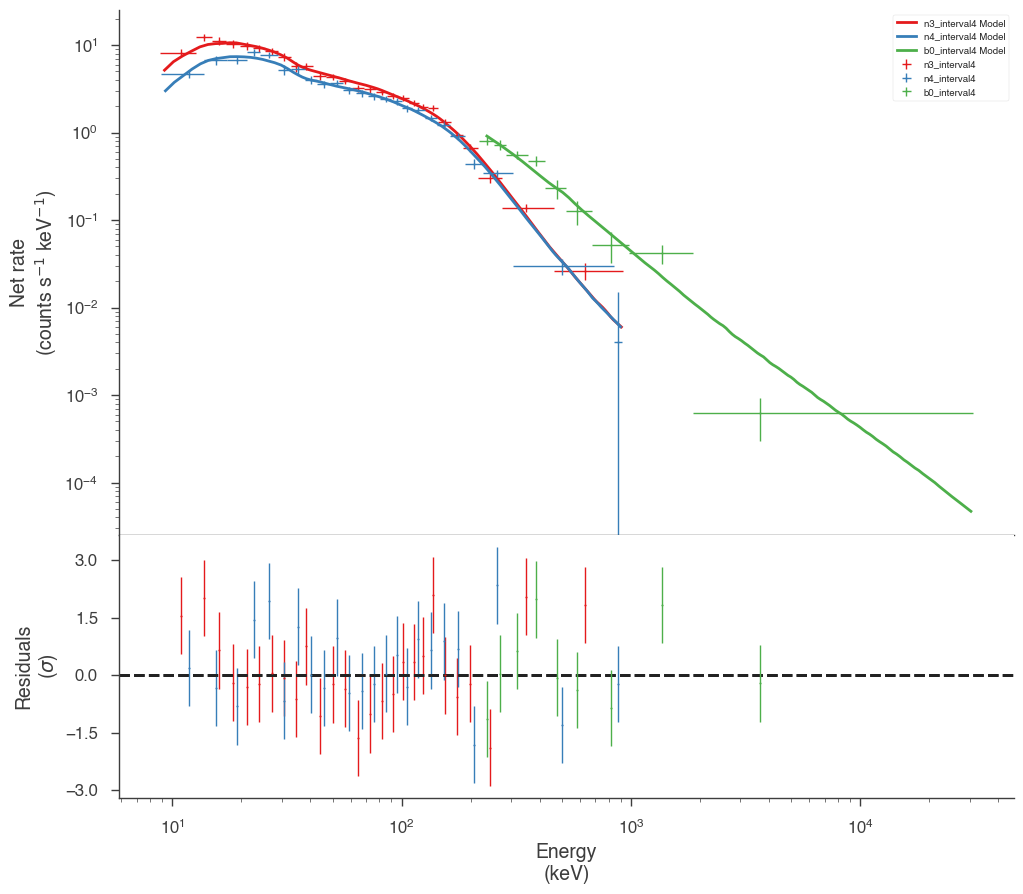

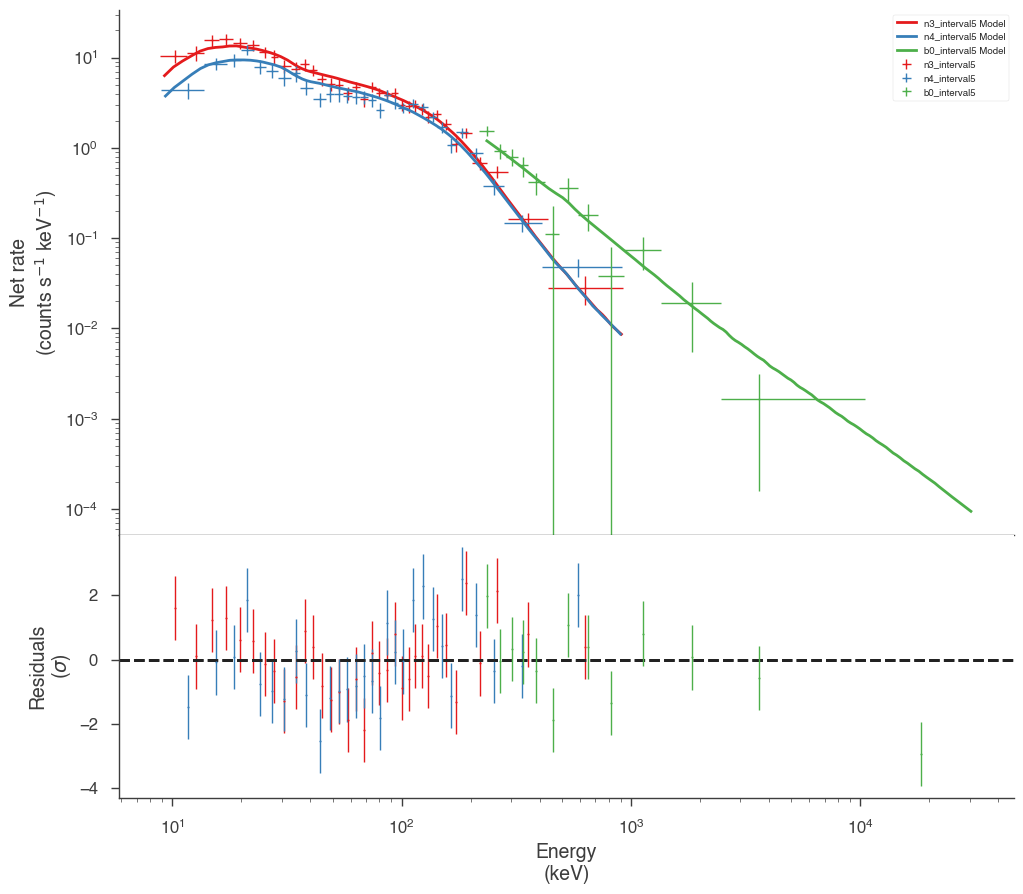

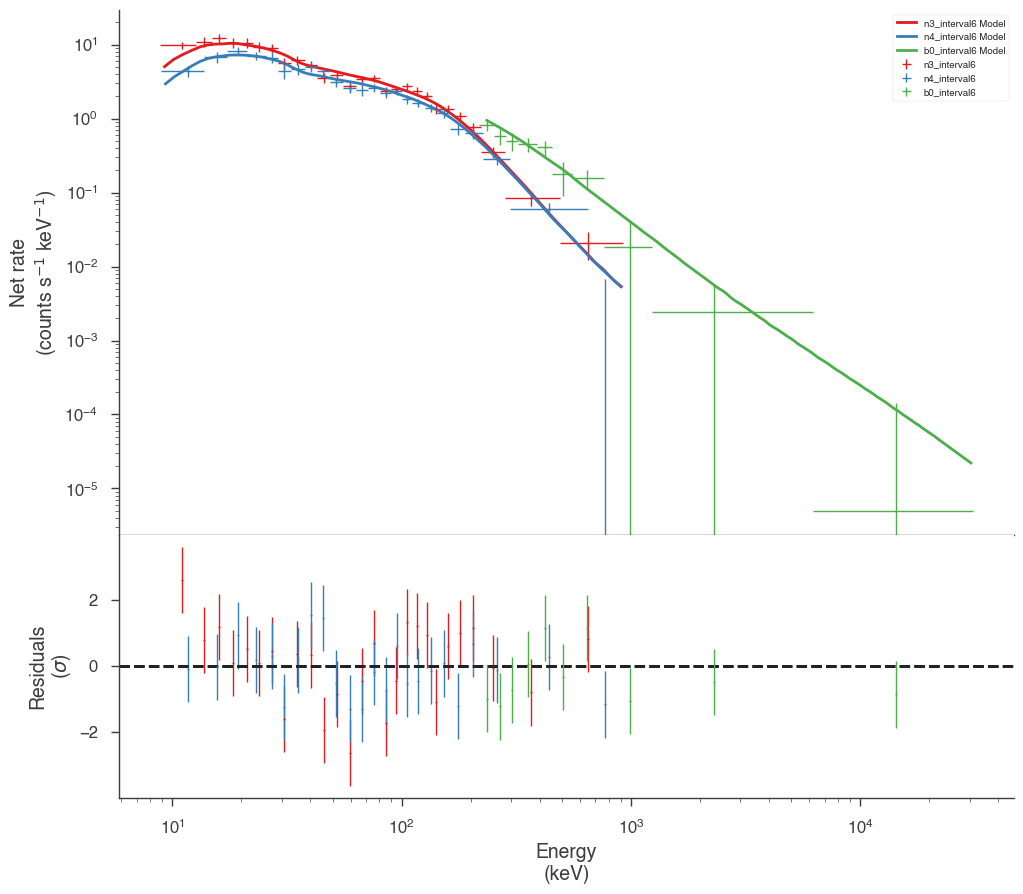

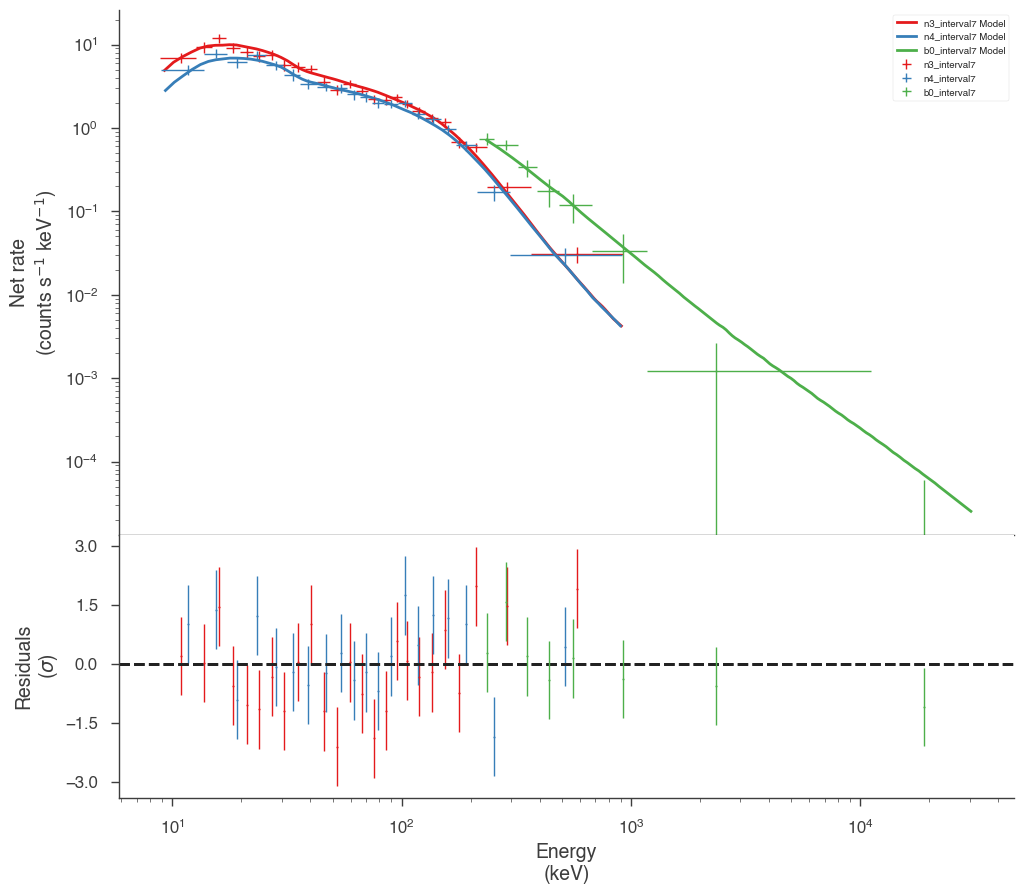

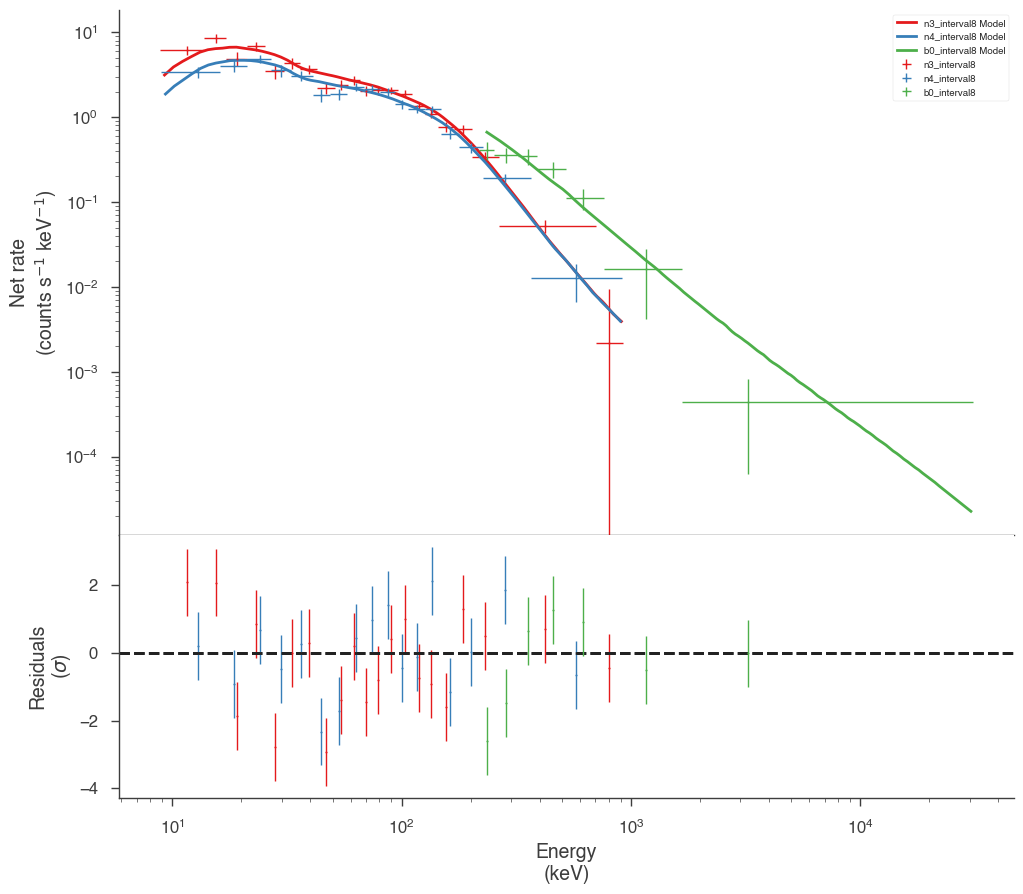

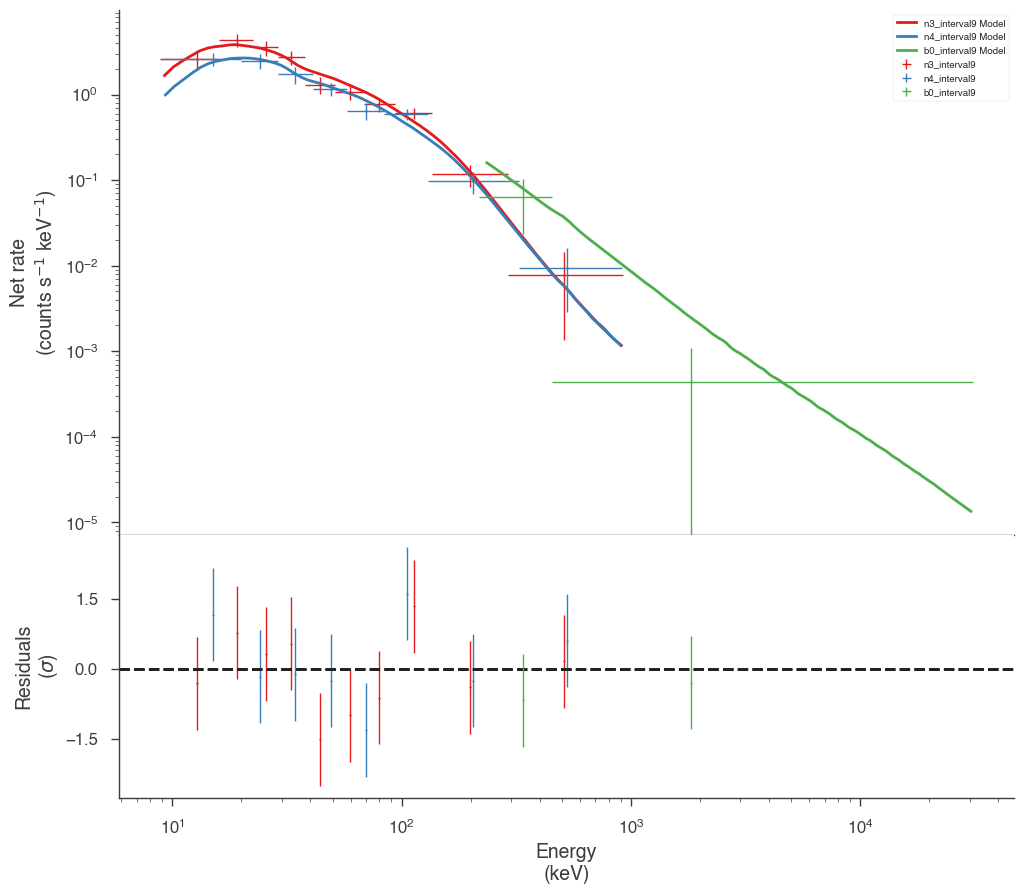

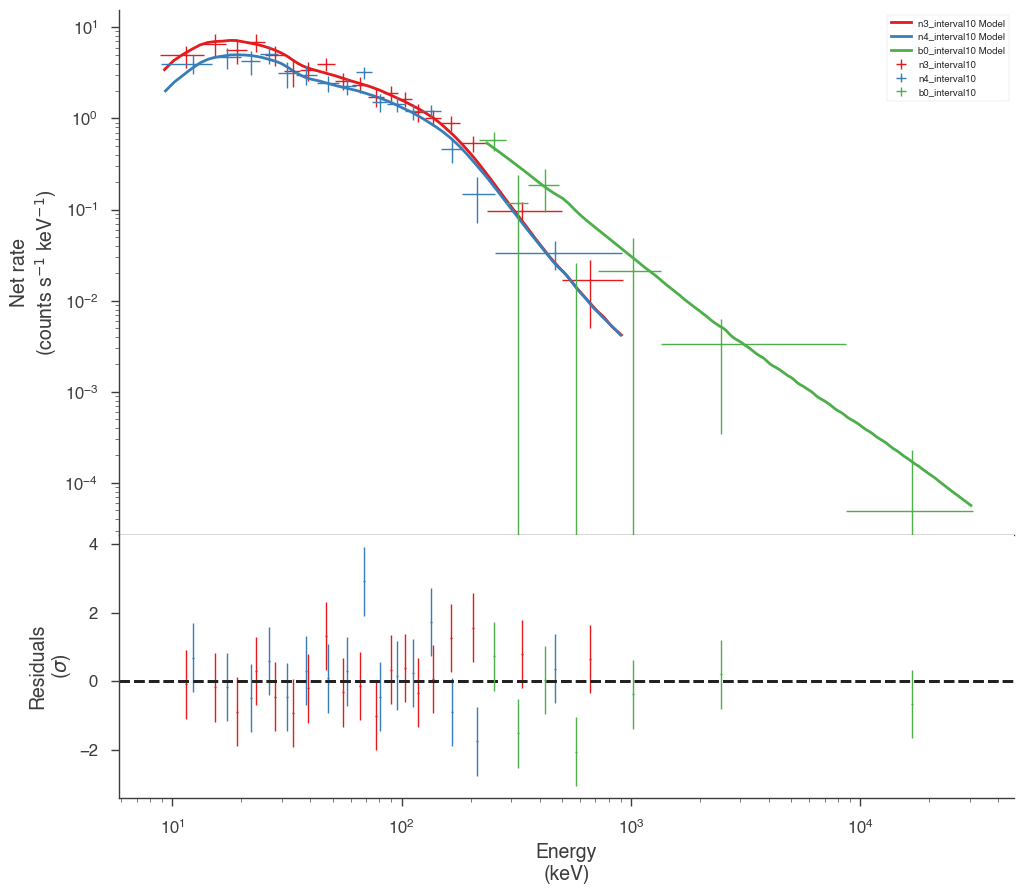

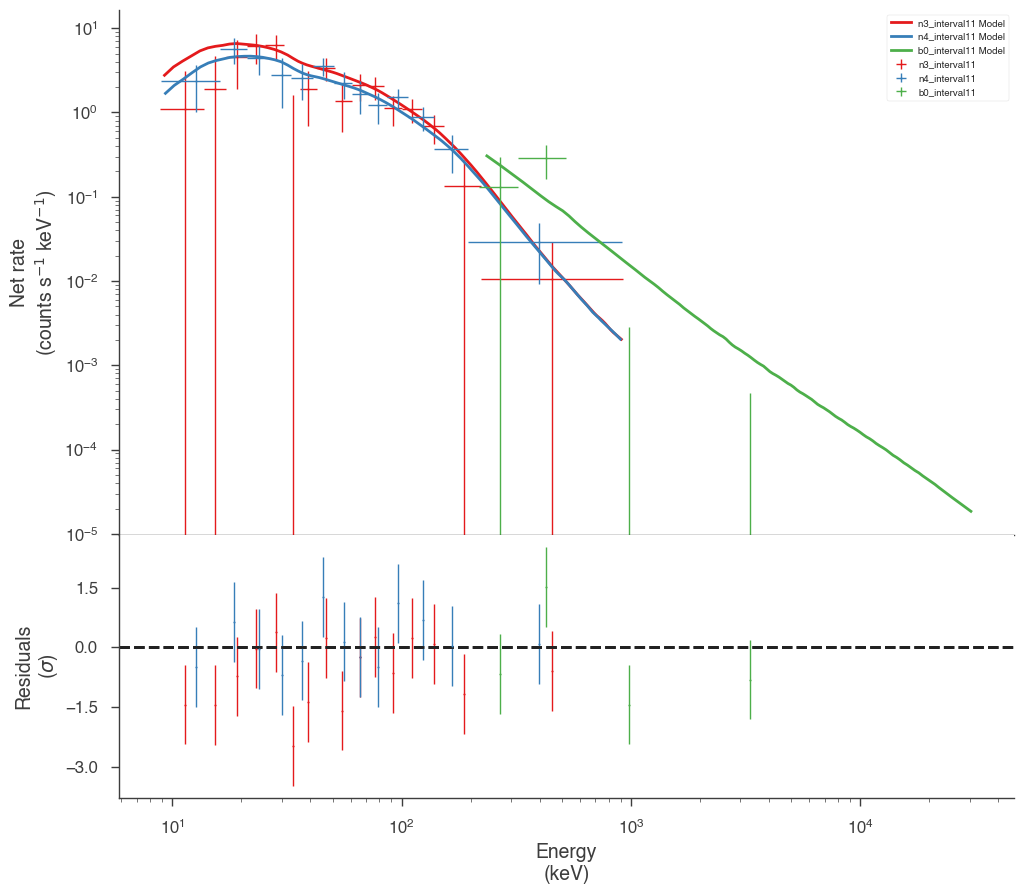

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

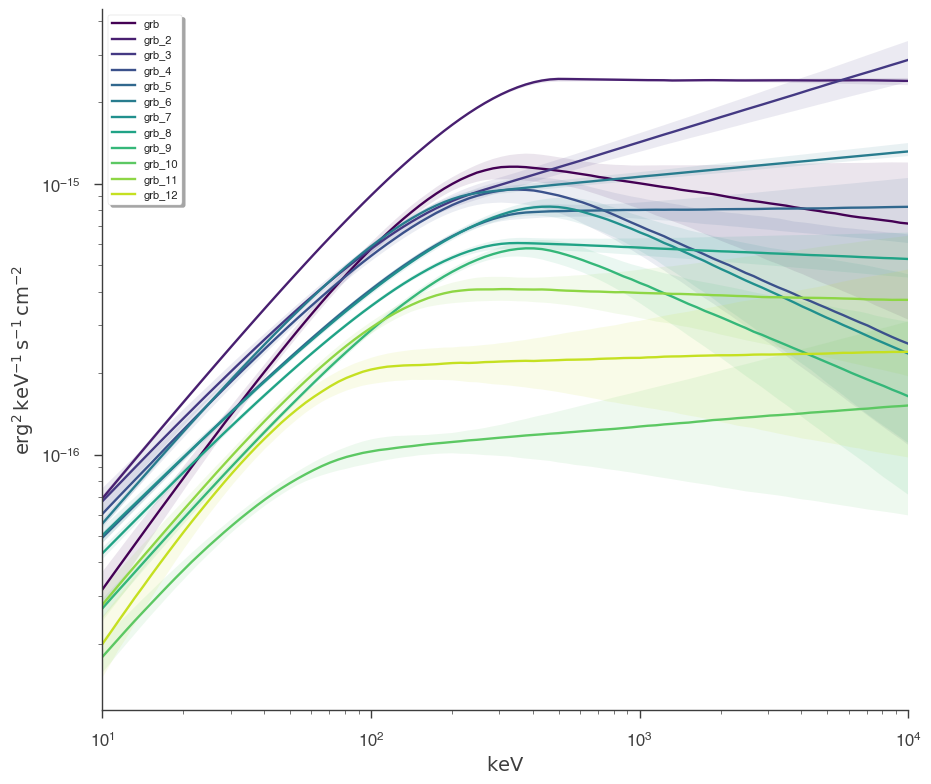

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.